# Baseline Soybean Classification

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from PIL import ImageFilter
import random

## File Paths

In [3]:
train_dir = "TrainData/"
train_ann = "TrainAnnotations.csv"

In [4]:
def load_data():
    """
    Load the image training data and classes
    :return: list of numpy arrays, list of integer labels, list of string filenames (for reference)
    """
    file_labels = pd.read_csv(train_ann)
    ann_dict = pd.Series(file_labels.annotation.values, index=file_labels.file_name).to_dict()
    image_dict = dict.fromkeys(ann_dict.keys())
    print("Loading image data...")
    for filename in list(ann_dict.keys()):
        image_dict[filename] = np.array(Image.open(train_dir + filename))
    print("Loading complete.")
    print("Preparing training data...")
    data = []
    labels = []
    names = []
    for filename in list(ann_dict):
        data.append(image_dict[filename])
        labels.append(ann_dict[filename])
        names.append(filename)
    print("Preparation complete.")
    return data, labels, names

X, y, filenames = load_data()


Loading image data...
Loading complete.
Preparing training data...
Preparation complete.


## Visualize the Data

In [4]:
def visualize_data(array):
    """
    Plot a given numpy array
    :param array: a numpy array (image)
    """
    if len(array.shape) == 3:  # has all 3 RGB channels
        plt.imshow(array)
    else:  # just a black and white image (one channel)
        plt.imshow(array, cmap='gray')
    plt.axis("off")
    plt.show()

## Feature Extraction Functions

In [5]:
def edge_filter(array, f_type="canny"):
    """
    Detect the edges within an image using a chosen filter
    :param array: a numpy array (image)
    :param f_type: the filter type in ['canny', 'laplacian', 'sobelx', 'sobely']
    :return: a numpy array (edge image)
    """
    edges = None
    if f_type == 'canny':
        edges = cv2.Canny(array, 120, 200)
    elif f_type == 'laplacian':
        # convert to grayscale --- one channel
        # Sobel filter in both directions
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Laplacian(array, cv2.CV_64F, ksize=5))
    elif f_type == "sobelx":
        # convert to grayscale --- one channel
        # get vertical edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 1, 0, ksize=5))
    elif f_type == "sobely":
        # convert to grayscale --- one channel
        # get horizontal edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 0, 1, ksize=5))
    return edges

def extract_channel(array, channel='green'):
    """
    Extract one channel from the image (default green because that is arguably the most important
    for this application)
    :param array: a numpy array (image)
    :param channel: string in ('red', 'green', 'blue')
    :return: a numpy array (image, one channel)
    """
    channel_dict = {'red': 0, 'green': 1, 'blue': 2}
    matrix = array[:, :, channel_dict[channel]]
    return matrix

def extract_sift(array):
    """
    Get the SIFT features from an image
    :param array: a numpy array (image)
    :return: key points, image of the key points
    """
    sift = cv2.xfeatures2d.SIFT_create(1000)
    key_points = sift.detect(array, None)
    image = cv2.drawKeypoints(array, key_points, np.array([]), (0, 0, 255),
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return key_points, image

def extract_pillow_edges(array, grayscale=False, visualize=False):
    """
    Get the result of pillow find_edges filter
    :param array:  a numpy array (image)
    :param visualize: to visualize the find_edge image or not [True, False]
    :return: find_edge vector (for training), find_edge image (for visualization)
    """
    image = Image.fromarray(array)      
    find_edge_image = image.filter(ImageFilter.FIND_EDGES)        
    if grayscale:
        find_edge_image = find_edge_image.convert("L")      
    find_edge_image_array = np.array(find_edge_image)
    if visualize:
        find_edge_image.show()         
    return find_edge_image_array
    
def extract_pillow_contour(array, grayscale=False, visualize=False):
    """
    Get the result of pillow contour filter
    :param array:  a numpy array (image)
    :param visualize: to visualize the contour image or not [True, False]
    :return: contour vector (for training), contour image (for visualization)
    """
    image = Image.fromarray(array)
    contour_image = image.filter(ImageFilter.CONTOUR)
    if grayscale:
        coutour_image = contour_image.convert("L")
    contour_image_array = np.array(contour_image)
    if visualize:
        contour_image.show()  
    return contour_image_array

def extract_pillow_emboss(array, grayscale=False, visualize=False):
    """
    Get the result of pillow emboss filter
    :param array:  a numpy array (image)
    :param visualize: to visualize the emboss image or not [True, False]
    :return: emboss vector (for training), emboss image (for visualization)
    """
    image = Image.fromarray(array)
    emboss_image = image.filter(ImageFilter.EMBOSS)        
    if grayscale:
        emboss_image = emboss_image.convert("L")    
    emboss_image_array = np.array(emboss_image)
    if visualize:
        emboss_image.show()          
    return emboss_image_array

def extract_hog(array, visualize=False):
    """
    Get the Histogram of Gradients of the image
    :param array: a numpy array (image)
    :param visualize: to visualize the HOG image or not [True, False]
    :return: HOG vector (for training), HOG image (for visualization)
    """
    if visualize:
        vector, im = hog(array,
                         orientations=8,
                         pixels_per_cell=(4, 4),
                         cells_per_block=(1, 1),
                         block_norm='L2-Hys',
                         feature_vector=True,
                         visualize=True)
        return vector, im
    else:
        vector = hog(array,
                     orientations=8,
                     pixels_per_cell=(4, 4),
                     cells_per_block=(1, 1),
                     feature_vector=True,
                     block_norm='L2-Hys')
        return vector

## Features

In [6]:
print("Extracting features...")
# lists of non-flattened numpy arrays
hogs = []
greens = []
edges = []
sifts = []
embosses = []
contours = []
sift_images = []  # for visualization only
for i in range(len(X)):
    if i % 10 == 0:
        print("Preprocessing Image", i+1, '/', len(X))
    hogs.append(extract_hog(X[i], visualize=False))
    greens.append(extract_channel(X[i], channel="green"))
    edges.append(extract_pillow_edges(X[i]))
    embosses.append(extract_pillow_emboss(X[i]))
    sift = extract_sift(X[i])
    sifts.append(sift[0])  # the key point vector that would actually be used for data representation
    sift_images.append(sift[1])  # the image, purely for visualization of those key points
    contours.append(extract_pillow_contour(X[i]))
print("Feature Extraction Complete.")

Extracting features...
Preprocessing Image 1 / 1025
Preprocessing Image 11 / 1025
Preprocessing Image 21 / 1025
Preprocessing Image 31 / 1025
Preprocessing Image 41 / 1025
Preprocessing Image 51 / 1025
Preprocessing Image 61 / 1025
Preprocessing Image 71 / 1025
Preprocessing Image 81 / 1025
Preprocessing Image 91 / 1025
Preprocessing Image 101 / 1025
Preprocessing Image 111 / 1025
Preprocessing Image 121 / 1025
Preprocessing Image 131 / 1025
Preprocessing Image 141 / 1025
Preprocessing Image 151 / 1025
Preprocessing Image 161 / 1025
Preprocessing Image 171 / 1025
Preprocessing Image 181 / 1025
Preprocessing Image 191 / 1025
Preprocessing Image 201 / 1025
Preprocessing Image 211 / 1025
Preprocessing Image 221 / 1025
Preprocessing Image 231 / 1025
Preprocessing Image 241 / 1025
Preprocessing Image 251 / 1025
Preprocessing Image 261 / 1025
Preprocessing Image 271 / 1025
Preprocessing Image 281 / 1025
Preprocessing Image 291 / 1025
Preprocessing Image 301 / 1025
Preprocessing Image 311 / 1

## Preview Random Image

### Do any visualization you want here befoer the data is flattened in the next section

Previewing image 007067.jpg from class 1


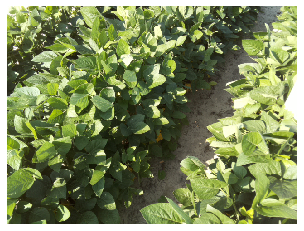

In [7]:
# RGB
index = random.randint(0, len(X))
print("Previewing image", filenames[index], "from class", y[index])
visualize_data(X[index])

In [8]:
# Edge
visualize_data(edges[index])

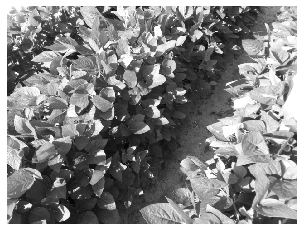

In [9]:
# Green
visualize_data(greens[index])

In [10]:
# Emboss
visualize_data(embosses[index])

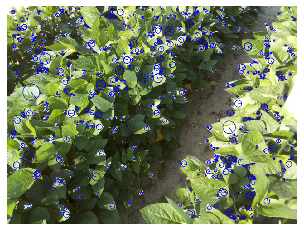

In [11]:
# SIFT
visualize_data(sift_images[index])

In [12]:
# Contour
visualize_data(contours[index])

## Flatten the Data

In [7]:
print("Flattening data...")
hogs = np.array([h.flatten() for h in hogs])
greens = [g.flatten() for g in greens]
edges = [e.flatten() for e in edges]
contours = [c.flatten() for c in contours]
# sifts does not need flattened
embosses = [e.flatten() for e in embosses]
print("Data flattening complete.")

Flattening data...
Data flattening complete.


## Train the Model

### RGB Features --- without transforming the input data

In [14]:
X = [X[i].flatten() for i in range(len(X))]

## Split the Data

In [15]:
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")

Vector size: (921600,)
Splitting the data...
Splitting complete.


## Hyperparameter optimization
Using `scikit-optimize`, the hyperparameters of the model can be optimized to maximize validation accuracy.

In [ ]:
from skopt.optimizer import gp_minimize
from skopt.space.space import Categorical, Integer, Real
from skopt.utils import use_named_args

kernel_dim = Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel')
degree_dim = Integer(low=3, high=8, name='degree') # only for 'poly' kernel
gamma_dim = Categorical(['scale', 'auto'], name='gamma')

shrinking_dim = Categorical([True, False], name='shrinking')
probability_dim = Categorical([True, False], name='probability')
tol_dim = Real(low=1e-4, high=1e-2, prior='log_uniform', name='tol')
random_state = 42

dimensions = [ kernel_dim, degree_dim, gamma_dim, shrinking_dim, probability_dim, tol_dim ]

@use_named_args(dimensions=dimensions)
def fitness(kernel, degree, gamma, shrinking, probability, tol):
    return 1 / fit_svm(kernel, degree, gamma, shrinking, probability, tol)

def fit_svm(kernel, degree, gamma, shrinking, probability, tol):
    print("Fitting with parameters kernel={}, degree={}, gamma={}, shrinking={}, probability={}, tol={}".format(kernel, degree, gamma, shrinking, probability, tol))
    clf = svm.SVC(kernel=kernel, 
                  degree=degree,
                  gamma=gamma,
                  shrinking=shrinking,
                  probability=probability,
                  tol=tol,
                  random_state=42)
    clf.fit(X_train, y_train)
    
    y_hat = clf.predict(X_train)
    train_accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
    print("Training Accuracy:", train_accuracy)
    
    # Predict on Validation Set (validation accuracy)
    print("Validating the model...")
    y_hat = clf.predict(X_valid)
    validation_accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
    print("Validation Accuracy:", validation_accuracy)
    return validation_accuracy


default_parameters = ['rbf', 3, 'scale', True, False, 1e-3]

print('Starting optimization...')
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=11,
                            x0=default_parameters,
                            random_state=random_state)

print(search_result.x)
print(search_result.fun)
print(1 / search_result.fun)

optimal_kernel = search_result.x[0]
optimal_degree = search_result.x[1]
optimal_gamma = search_result.x[2]
optimal_shrinking = search_result.x[3]
optimal_probability = search_result.x[4]
optimal_tol = search_result.x[5]

print("Best hyperparameters found: ")
print("    kernel=", optimal_kernel)

if optimal_kernel == 'poly':
    print("    degree=", optimal_degree)

if optimal_kernel == 'rbf' or optimal_kernel == 'poly' or optimal_kernel == 'sigmoid':
    print("    gamma=", optimal_gamma)

print("    shrinking=", optimal_shrinking)
print("    probability=", optimal_probability)
print("    tol=", optimal_tol)

In [16]:
print("Training the model...")
clf = svm.SVC(kernel="poly", degree=5, random_state=42, probability=True, tol=0.99721059972106)
clf.fit(X_train, y_train)
print("Training complete.")

Training the model...
Training complete.


In [17]:
# Training Accuracy
y_hat = clf.predict(X_train)
print(list(y_train))
print(list(y_hat))
accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
print()
print("Training Accuracy:", accuracy)

[0, 0, 0, 0, 0, 4, 2, 3, 2, 0, 1, 1, 3, 0, 0, 2, 0, 3, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 1, 4, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 2, 0, 4, 1, 2, 1, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 4, 4, 2, 2, 2, 0, 3, 0, 1, 0, 3, 0, 2, 0, 4, 1, 1, 3, 1, 1, 3, 0, 0, 3, 1, 2, 1, 0, 1, 4, 0, 0, 0, 0, 0, 1, 4, 3, 1, 0, 1, 3, 0, 1, 4, 0, 0, 2, 0, 0, 0, 3, 2, 0, 1, 2, 3, 1, 1, 1, 2, 0, 3, 0, 3, 1, 2, 4, 1, 0, 1, 1, 1, 2, 0, 3, 4, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 1, 4, 1, 0, 0, 1, 3, 0, 2, 1, 1, 2, 1, 0, 0, 3, 2, 0, 1, 2, 0, 4, 3, 0, 0, 0, 4, 1, 0, 0, 0, 3, 2, 2, 3, 4, 0, 0, 4, 0, 0, 1, 0, 0, 3, 2, 1, 2, 1, 0, 0, 0, 0, 1, 3, 3, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 1, 3, 3, 0, 0, 0, 3, 3, 2, 0, 2, 0, 3, 3, 4, 4, 2, 1, 3, 2, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 0, 4, 3, 1, 3, 0, 1, 0, 0, 4, 1, 1, 2, 0, 1, 4, 0, 4, 0, 3, 0, 3, 0, 0, 0, 3, 1, 0, 2, 4, 3, 4, 0, 0, 0, 1, 0, 0, 2, 4, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 4, 4, 0, 0, 0, 3, 0, 2, 3, 1, 2, 1, 1, 3, 1, 3, 0, 0, 0, 

## Validate the Model

In [18]:
# Predict on Validation Set (validation accuracy)
print("Validating the model...")
y_hat = clf.predict(X_valid)
print()
print(list(y_valid))
print(list(y_hat))
accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
print()
print("Validation Accuracy:", accuracy)

Validating the model...

[2, 4, 1, 2, 3, 3, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 1, 1, 3, 0, 3, 0, 1, 0, 1, 0, 2, 1, 0, 0, 4, 0, 0, 0, 1, 2, 0, 2, 1, 3, 0, 0, 1, 1, 0, 1, 4, 4, 0, 3, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 4, 0, 3, 4, 2, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 4, 2, 3, 0, 1, 4, 3, 2, 3, 0, 0, 2, 3, 0, 3, 0, 3, 0, 4, 3, 0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 3, 3, 0, 1, 0, 1, 3, 2, 0, 0, 3, 0, 1, 1, 1, 1, 3, 0, 4, 0, 1, 0, 0, 0, 2, 4, 3, 0, 0, 1, 0, 2, 4, 0, 0, 1, 3, 1, 0, 0, 1, 0, 0, 3, 2, 0, 2, 1, 0, 0, 4, 1, 0, 3, 0, 0, 2, 0, 3, 3, 1, 4, 2, 0, 3, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 4, 1, 2, 1, 3, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 1, 0, 4, 3, 4, 0, 0, 2, 4, 0, 0, 3, 0, 1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 2, 3, 0, 1, 0, 2, 2, 0, 1, 0, 4, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 1, 0, 4, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 3, 4, 3, 2, 1, 3, 1, 0, 0, 0, 1, 2, 0, 4, 3, 2, 0, 0]
[2, 4, 1, 2, 2, 3, 0, 2, 1, 0, 0, 0, 2, 4, 0, 0, 3

## Choose Specific Feature Representation
#### The features with which you'd like to represent each image

In [19]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, _, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), hogs[i], greens[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.


## Split the Data

In [20]:
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")

Vector size: (460800,)
Splitting the data...
Splitting complete.


In [21]:
print("Training the model...")
clf = svm.SVC(kernel="poly", degree=5, random_state=42, probability=True, tol=0.99721059972106)
clf.fit(X_train, y_train)
print("Training complete.")

Training the model...
Training complete.


In [22]:
# Training Accuracy
y_hat = clf.predict(X_train)
print(list(y_train))
print(list(y_hat))
accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
print()
print("Training Accuracy:", accuracy)

[0, 0, 0, 0, 0, 4, 2, 3, 2, 0, 1, 1, 3, 0, 0, 2, 0, 3, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 1, 4, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 2, 0, 4, 1, 2, 1, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 4, 4, 2, 2, 2, 0, 3, 0, 1, 0, 3, 0, 2, 0, 4, 1, 1, 3, 1, 1, 3, 0, 0, 3, 1, 2, 1, 0, 1, 4, 0, 0, 0, 0, 0, 1, 4, 3, 1, 0, 1, 3, 0, 1, 4, 0, 0, 2, 0, 0, 0, 3, 2, 0, 1, 2, 3, 1, 1, 1, 2, 0, 3, 0, 3, 1, 2, 4, 1, 0, 1, 1, 1, 2, 0, 3, 4, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 1, 4, 1, 0, 0, 1, 3, 0, 2, 1, 1, 2, 1, 0, 0, 3, 2, 0, 1, 2, 0, 4, 3, 0, 0, 0, 4, 1, 0, 0, 0, 3, 2, 2, 3, 4, 0, 0, 4, 0, 0, 1, 0, 0, 3, 2, 1, 2, 1, 0, 0, 0, 0, 1, 3, 3, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 1, 3, 3, 0, 0, 0, 3, 3, 2, 0, 2, 0, 3, 3, 4, 4, 2, 1, 3, 2, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 0, 4, 3, 1, 3, 0, 1, 0, 0, 4, 1, 1, 2, 0, 1, 4, 0, 4, 0, 3, 0, 3, 0, 0, 0, 3, 1, 0, 2, 4, 3, 4, 0, 0, 0, 1, 0, 0, 2, 4, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 4, 4, 0, 0, 0, 3, 0, 2, 3, 1, 2, 1, 1, 3, 1, 3, 0, 0, 0, 

## Validate the Model

In [23]:
# Predict on Validation Set (validation accuracy)
print("Validating the model...")
y_hat = clf.predict(X_valid)
print()
print(list(y_valid))
print(list(y_hat))
accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
print()
print("Validation Accuracy:", accuracy)

Validating the model...

[2, 4, 1, 2, 3, 3, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 1, 1, 3, 0, 3, 0, 1, 0, 1, 0, 2, 1, 0, 0, 4, 0, 0, 0, 1, 2, 0, 2, 1, 3, 0, 0, 1, 1, 0, 1, 4, 4, 0, 3, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 4, 0, 3, 4, 2, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 4, 2, 3, 0, 1, 4, 3, 2, 3, 0, 0, 2, 3, 0, 3, 0, 3, 0, 4, 3, 0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 3, 3, 0, 1, 0, 1, 3, 2, 0, 0, 3, 0, 1, 1, 1, 1, 3, 0, 4, 0, 1, 0, 0, 0, 2, 4, 3, 0, 0, 1, 0, 2, 4, 0, 0, 1, 3, 1, 0, 0, 1, 0, 0, 3, 2, 0, 2, 1, 0, 0, 4, 1, 0, 3, 0, 0, 2, 0, 3, 3, 1, 4, 2, 0, 3, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 4, 1, 2, 1, 3, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 1, 0, 4, 3, 4, 0, 0, 2, 4, 0, 0, 3, 0, 1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 2, 3, 0, 1, 0, 2, 2, 0, 1, 0, 4, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 1, 0, 4, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 3, 4, 3, 2, 1, 3, 1, 0, 0, 0, 1, 2, 0, 4, 3, 2, 0, 0]
[2, 4, 1, 2, 2, 3, 0, 2, 0, 0, 0, 0, 2, 4, 0, 0, 3

## Green Channel
#### The features with which you'd like to represent each image

In [8]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, _, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), greens[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.


## Split the Data

In [9]:
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")

Vector size: (307200,)
Splitting the data...
Splitting complete.


## Train the Model

In [10]:
print("Training the model...")
clf = svm.SVC(kernel="poly", degree=5, random_state=42, probability=True, tol=0.99721059972106)
clf.fit(X_train, y_train)
print("Training complete.")

Training the model...
Training complete.


In [11]:
# Training Accuracy
y_hat = clf.predict(X_train)
print(list(y_train))
print(list(y_hat))
accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
print()
print("Training Accuracy:", accuracy)

[0, 0, 0, 0, 0, 4, 2, 3, 2, 0, 1, 1, 3, 0, 0, 2, 0, 3, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 2, 1, 4, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 2, 0, 4, 1, 2, 1, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 4, 4, 2, 2, 2, 0, 3, 0, 1, 0, 3, 0, 2, 0, 4, 1, 1, 3, 1, 1, 3, 0, 0, 3, 1, 2, 1, 0, 1, 4, 0, 0, 0, 0, 0, 1, 4, 3, 1, 0, 1, 3, 0, 1, 4, 0, 0, 2, 0, 0, 0, 3, 2, 0, 1, 2, 3, 1, 1, 1, 2, 0, 3, 0, 3, 1, 2, 4, 1, 0, 1, 1, 1, 2, 0, 3, 4, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 1, 4, 1, 0, 0, 1, 3, 0, 2, 1, 1, 2, 1, 0, 0, 3, 2, 0, 1, 2, 0, 4, 3, 0, 0, 0, 4, 1, 0, 0, 0, 3, 2, 2, 3, 4, 0, 0, 4, 0, 0, 1, 0, 0, 3, 2, 1, 2, 1, 0, 0, 0, 0, 1, 3, 3, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 1, 3, 3, 0, 0, 0, 3, 3, 2, 0, 2, 0, 3, 3, 4, 4, 2, 1, 3, 2, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 0, 4, 3, 1, 3, 0, 1, 0, 0, 4, 1, 1, 2, 0, 1, 4, 0, 4, 0, 3, 0, 3, 0, 0, 0, 3, 1, 0, 2, 4, 3, 4, 0, 0, 0, 1, 0, 0, 2, 4, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 4, 4, 0, 0, 0, 3, 0, 2, 3, 1, 2, 1, 1, 3, 1, 3, 0, 0, 0, 

## Validate the Model

In [12]:
# Predict on Validation Set (validation accuracy)
print("Validating the model...")
y_hat = clf.predict(X_valid)
print()
print(list(y_valid))
print(list(y_hat))
accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
print()
print("Validation Accuracy:", accuracy)

Validating the model...

[2, 4, 1, 2, 3, 3, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 1, 1, 3, 0, 3, 0, 1, 0, 1, 0, 2, 1, 0, 0, 4, 0, 0, 0, 1, 2, 0, 2, 1, 3, 0, 0, 1, 1, 0, 1, 4, 4, 0, 3, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 4, 0, 3, 4, 2, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 4, 2, 3, 0, 1, 4, 3, 2, 3, 0, 0, 2, 3, 0, 3, 0, 3, 0, 4, 3, 0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 3, 3, 0, 1, 0, 1, 3, 2, 0, 0, 3, 0, 1, 1, 1, 1, 3, 0, 4, 0, 1, 0, 0, 0, 2, 4, 3, 0, 0, 1, 0, 2, 4, 0, 0, 1, 3, 1, 0, 0, 1, 0, 0, 3, 2, 0, 2, 1, 0, 0, 4, 1, 0, 3, 0, 0, 2, 0, 3, 3, 1, 4, 2, 0, 3, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 4, 1, 2, 1, 3, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 1, 0, 4, 3, 4, 0, 0, 2, 4, 0, 0, 3, 0, 1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 2, 3, 0, 1, 0, 2, 2, 0, 1, 0, 4, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 1, 0, 4, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 3, 4, 3, 2, 1, 3, 1, 0, 0, 0, 1, 2, 0, 4, 3, 2, 0, 0]
[2, 4, 1, 2, 2, 3, 0, 2, 0, 0, 0, 0, 2, 4, 0, 0, 3

## Choose HOG + Green Feature Representation


In [15]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, _, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), hogs[i], greens[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.


## Split the Data

In [16]:
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")



Vector size: (460800,)
Splitting the data...
Splitting complete.


## Hyperparameter optimization
Using `scikit-optimize`, the hyperparameters of the model can be optimized to maximize validation accuracy.

In [17]:
from skopt.optimizer import gp_minimize
from skopt.space.space import Categorical, Integer, Real
from skopt.utils import use_named_args

kernel_dim = Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel')
degree_dim = Integer(low=3, high=8, name='degree') # only for 'poly' kernel
gamma_dim = Categorical(['scale', 'auto'], name='gamma')

shrinking_dim = Categorical([True, False], name='shrinking')
probability_dim = Categorical([True, False], name='probability')
tol_dim = Real(low=1e-4, high=1e-2, prior='log_uniform', name='tol')
random_state = 42

dimensions = [ kernel_dim, degree_dim, gamma_dim, shrinking_dim, probability_dim, tol_dim ]

@use_named_args(dimensions=dimensions)
def fitness(kernel, degree, gamma, shrinking, probability, tol):
    return 1 / fit_svm(kernel, degree, gamma, shrinking, probability, tol)

def fit_svm(kernel, degree, gamma, shrinking, probability, tol):
    print("Fitting with parameters kernel={}, degree={}, gamma={}, shrinking={}, probability={}, tol={}".format(kernel, degree, gamma, shrinking, probability, tol))
    clf = svm.SVC(kernel=kernel, 
                  degree=degree,
                  gamma=gamma,
                  shrinking=shrinking,
                  probability=probability,
                  tol=tol,
                  random_state=42)
    clf.fit(X_train, y_train)
    
    y_hat = clf.predict(X_train)
    train_accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
    print("Training Accuracy:", train_accuracy)
    
    # Predict on Validation Set (validation accuracy)
    print("Validating the model...")
    y_hat = clf.predict(X_valid)
    validation_accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
    print("Validation Accuracy:", validation_accuracy)
    return validation_accuracy


default_parameters = ['rbf', 3, 'scale', True, False, 1e-3]

print('Starting optimization...')
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=11,
                            x0=default_parameters,
                            random_state=random_state)

print(search_result.x)
print(search_result.fun)
print(1 / search_result.fun)

optimal_kernel = search_result.x[0]
optimal_degree = search_result.x[1]
optimal_gamma = search_result.x[2]
optimal_shrinking = search_result.x[3]
optimal_probability = search_result.x[4]
optimal_tol = search_result.x[5]

print("Best hyperparameters found: ")
print("    kernel=", optimal_kernel)

if optimal_kernel == 'poly':
    print("    degree=", optimal_degree)

if optimal_kernel == 'rbf' or optimal_kernel == 'poly' or optimal_kernel == 'sigmoid':
    print("    gamma=", optimal_gamma)

print("    shrinking=", optimal_shrinking)
print("    probability=", optimal_probability)
print("    tol=", optimal_tol)


Starting optimization...
Fitting with parameters kernel=rbf, degree=3, gamma=scale, shrinking=True, probability=False, tol=0.001
Training Accuracy: 0.806136680613668
Validating the model...
Validation Accuracy: 0.711038961038961
Fitting with parameters kernel=sigmoid, degree=4, gamma=auto, shrinking=False, probability=True, tol=0.00015847101210439096
Training Accuracy: 0.4755927475592748
Validating the model...
Validation Accuracy: 0.4772727272727273
Fitting with parameters kernel=poly, degree=5, gamma=scale, shrinking=False, probability=True, tol=0.0027796975515266826
Training Accuracy: 0.99721059972106
Validating the model...
Validation Accuracy: 0.8311688311688312
Fitting with parameters kernel=sigmoid, degree=3, gamma=auto, shrinking=False, probability=False, tol=0.0001033076804324041
Training Accuracy: 0.4755927475592748
Validating the model...
Validation Accuracy: 0.4772727272727273
Fitting with parameters kernel=linear, degree=6, gamma=scale, shrinking=True, probability=False, t